In [1]:
%matplotlib inline

#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Período treinamento
treinamento_start_date = '2013-04-28'
treinamento_end_date = '2018-12-31'

#Período teste 
#OBS. As datas abaixo somente serão utilizadas futuramente nos modelos de previsão para testar os algoritmos
teste_start_date = '2019-01-01'
teste_end_date = '2019-12-31'

In [3]:
# Moedas que serão utilizadas 
tickers = ['GLD', 'BTC-USD']

In [4]:
# Utilização do pandas_datareader para carregar os dados de treinamento do Yahoo Finance
treinamento_dataset_GLD = data.DataReader(tickers[0], 'yahoo', treinamento_start_date, treinamento_end_date)
treinamento_dataset_BTC_USD = data.DataReader(tickers[1], 'yahoo', treinamento_start_date, treinamento_end_date)

In [5]:
# O pandas_datareader será usado para carregar os dados de treinamento do Yahoo Finance
treinamento_dataset_GLD = data.DataReader(tickers[0], 'yahoo', treinamento_start_date, treinamento_end_date)
treinamento_dataset_BTC_USD = data.DataReader(tickers[1], 'yahoo', treinamento_start_date, treinamento_end_date)

In [6]:
# pandas_datareader para carregar os dados de teste do Yahoo Finance da moeda OURO. 
# O dataset abaixo será utilizado nos modelos de previsão
teste_dataset_GLD = data.DataReader(tickers[0], 'yahoo', teste_start_date, teste_end_date)

In [7]:
#O head é utilizado para exibir as primeiras 5 linhas do dataset do OURO.
treinamento_dataset_GLD.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-04-29,142.660004,141.490005,142.130005,142.300003,11004500,142.300003
2013-04-30,142.830002,141.550003,142.270004,142.770004,11284400,142.770004
2013-05-01,141.550003,139.300003,140.589996,141.110001,13931100,141.110001
2013-05-02,142.470001,141.639999,142.000000,141.919998,11502200,141.919998
2013-05-03,142.710007,141.399994,141.699997,142.089996,11667100,142.089996


In [8]:
#Descrição estatística do dataset da moeda OURO.
treinamento_dataset_GLD.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1430.000000,1430.000000,1430.000000,1430.000000,1.430000e+03,1430.000000
mean,120.057238,119.076252,119.562406,119.561559,7.991788e+06,119.561559
std,7.215634,7.117641,7.160455,7.179836,4.150320e+06,7.179836
min,100.989998,100.230003,100.919998,100.500000,1.501600e+06,100.500000
25%,115.769997,114.697502,115.162502,115.199997,5.178100e+06,115.199997
50%,120.205002,119.299999,119.739998,119.725002,7.166150e+06,119.725002
75%,125.247499,124.315001,124.787500,124.690002,9.733725e+06,124.690002
max,142.830002,141.639999,142.330002,142.770004,4.913900e+07,142.770004


In [9]:
#Verifica se GLD tem algum valor nulo
treinamento_dataset_GLD.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [10]:
#Verifica se GLD tem algum valor nulo
teste_dataset_GLD.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento do GLD')

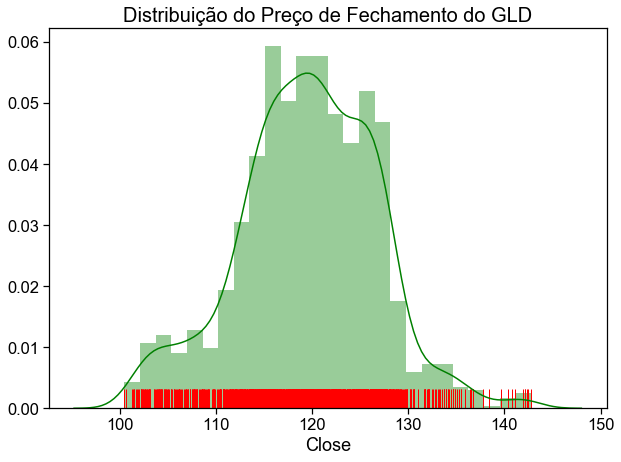

In [14]:
#Histograma do Fechamento do GLD
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(treinamento_dataset_GLD['Close'], color= 'red')
sns.distplot(treinamento_dataset_GLD['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento do GLD')

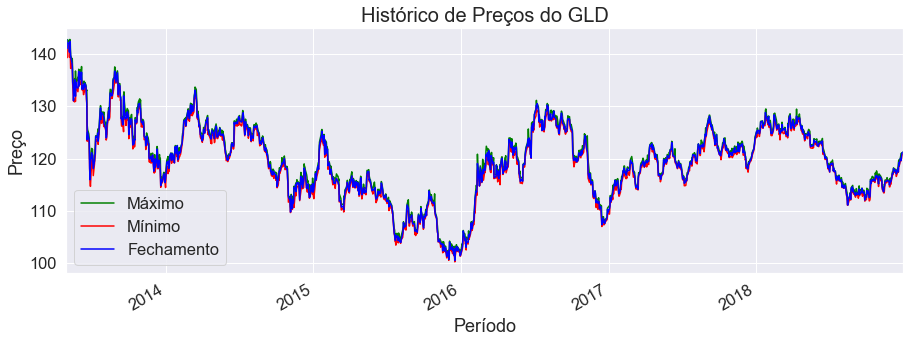

In [16]:
#Plotagem da série histórica do GLD utilizando o máximo, mínimo e fechamento.
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['High'].plot(label = 'Máximo', color = 'green')
treinamento_dataset_GLD['Low'].plot(label = 'Mínimo', color = 'red')
treinamento_dataset_GLD['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do GLD')
plt.legend();

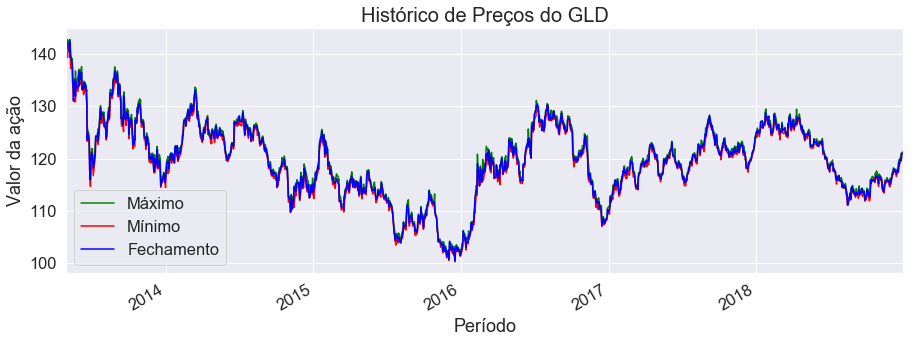

In [17]:
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['High'].plot(label = 'Máximo', color = 'green')
treinamento_dataset_GLD['Low'].plot(label = 'Mínimo', color = 'red')
treinamento_dataset_GLD['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do GLD')
plt.legend();

In [18]:
#Criação da Variação
treinamento_dataset_GLD['Variation'] = treinamento_dataset_GLD['Close'].sub(treinamento_dataset_GLD['Open'])

In [19]:
treinamento_dataset_GLD.head()

,High,Low,Open,Close,Volume,Adj Close,Variation
Date,,,,,,,
2013-04-29,142.660004,141.490005,142.130005,142.300003,11004500,142.300003,0.169998
2013-04-30,142.830002,141.550003,142.270004,142.770004,11284400,142.770004,0.500000
2013-05-01,141.550003,139.300003,140.589996,141.110001,13931100,141.110001,0.520004
2013-05-02,142.470001,141.639999,142.000000,141.919998,11502200,141.919998,-0.080002
2013-05-03,142.710007,141.399994,141.699997,142.089996,11667100,142.089996,0.389999


In [20]:
import plotly.offline as py

Text(0.5, 1.0, 'Variação de preço diário do GLD')

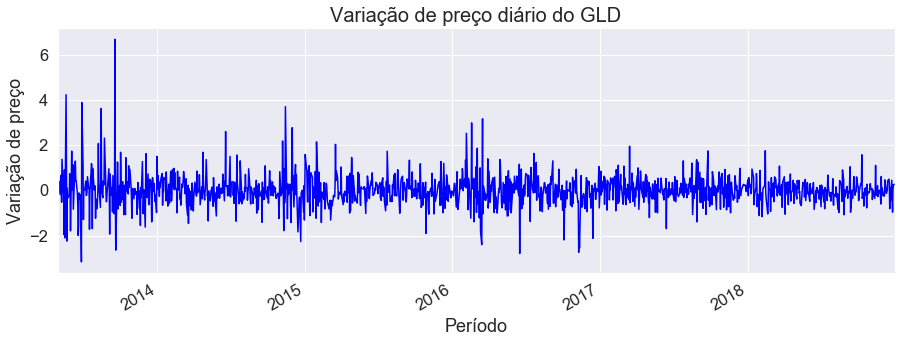

In [23]:
#Plotagem da variação de preço
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['Variation'].plot(label = 'Variação de preço', color = 'blue')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário do GLD')

Text(0.5, 1.0, 'Variação de preço diário do GLD')

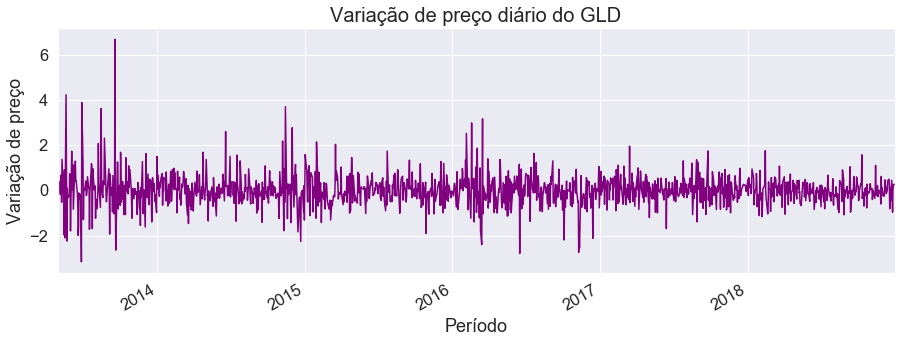

In [24]:
#Plotagem da variação de preço
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['Variation'].plot(label = 'Variação de preço', color = 'purple')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário do GLD')

In [26]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_variation_GLD = treinamento_dataset_GLD['Variation'].values.argmax()
max_value_GLD = treinamento_dataset_GLD['Variation'].values[max_variation_GLD,]
treinamento_dataset_GLD['Variation'][treinamento_dataset_GLD['Variation'].values == max_value_GLD]

Date
2013-09-18    6.689995
Name: Variation, dtype: float64

Text(0.5, 1.0, 'Volume negociado do GLD')

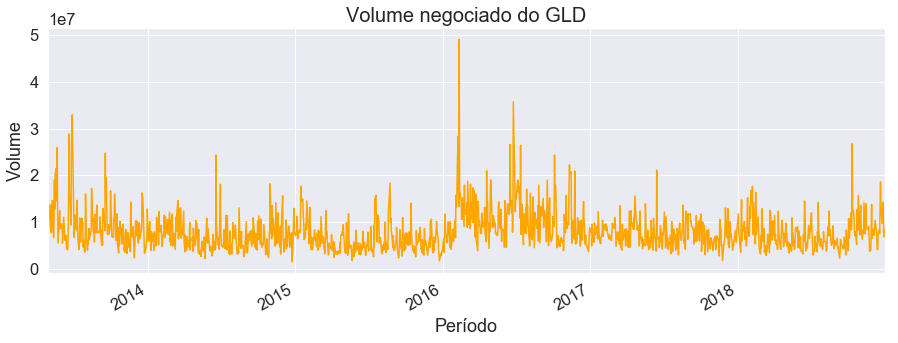

In [27]:
#Plotagem do volume 
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['Volume'].plot(label = 'Volume', color = 'orange')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado do GLD')

Text(0.5, 1.0, 'Volume negociado do GLD')

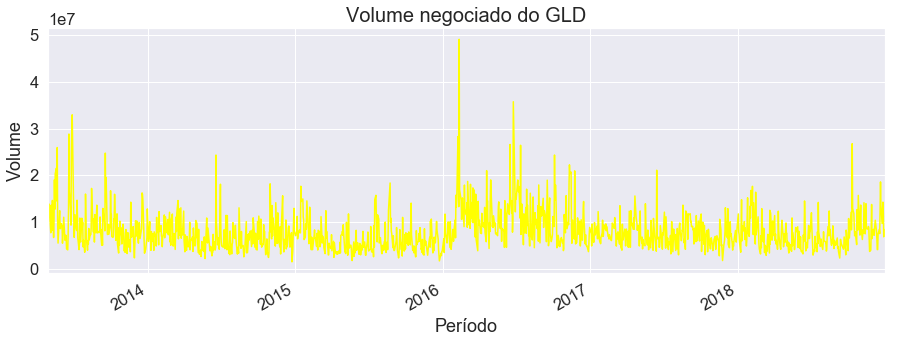

In [28]:
#Plotagem do volume 
plt.figure(figsize=(15,5))
treinamento_dataset_GLD['Volume'].plot(label = 'Volume', color = 'yellow')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado do GLD')

In [30]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_volume_GLD = treinamento_dataset_GLD['Volume'].values.argmax()
max_value_GLD = treinamento_dataset_GLD['Volume'].values[max_variation_GLD,]
treinamento_dataset_GLD['Volume'][treinamento_dataset_GLD['Volume'].values == max_value_GLD]

Date
2013-09-18    24780000
Name: Volume, dtype: int64

In [34]:
#O head é utilizado para exibir as primeiras 5 linhas do dataset do Bitcoin.
treinamento_dataset_BTC_USD.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [35]:
#O describe é utilizado para retornar uma descrição estatistica.
treinamento_dataset_BTC_USD.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1568.000000,1568.000000,1568.000000,1568.000000,1.568000e+03,1568.000000
mean,3004.183923,2817.755218,2916.459327,2918.367399,1.998481e+09,2918.367399
std,3868.218540,3559.448876,3729.664555,3728.962180,3.383297e+09,3728.962180
min,211.731003,171.509995,176.897003,178.102997,5.914570e+06,178.102997
25%,379.126740,363.145500,371.203262,370.957756,4.040165e+07,370.957756
50%,737.738495,708.824493,719.798004,726.533020,1.149075e+08,726.533020
75%,5838.350098,5522.435059,5715.119873,5712.787476,3.534788e+09,5712.787476
max,20089.000000,18974.099609,19475.800781,19497.400391,2.384090e+10,19497.400391


In [36]:
#Verifica se BTC-USD tem algum valor nulo
teste_dataset_GLD.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [37]:
#Criação da Variação
treinamento_dataset_BTC_USD['Variation'] = treinamento_dataset_BTC_USD['Close'].sub(treinamento_dataset_BTC_USD['Open'])

In [38]:
treinamento_dataset_BTC_USD.head()

,High,Low,Open,Close,Volume,Adj Close,Variation
Date,,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,-8.529999
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,-32.419983
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,-29.307007
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,14.230988
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,-9.263977


In [40]:
#Verifica se BTC-USD tem algum valor nulo
treinamento_dataset_BTC_USD.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Variation    0
dtype: int64

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento do BTC-USD')

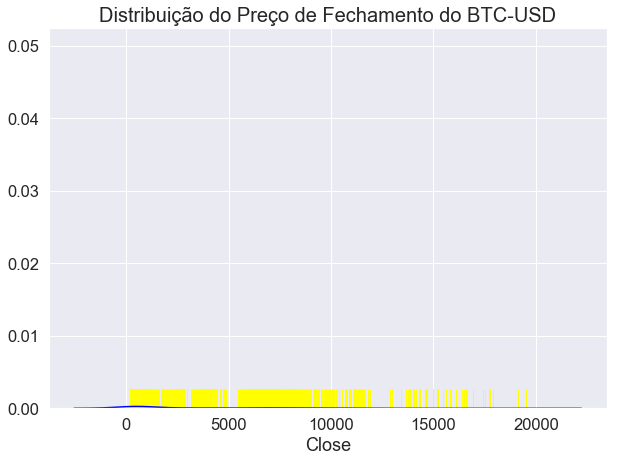

In [41]:
#Histograma do Fechamento do GLD
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(treinamento_dataset_BTC_USD['Close'], color= 'yellow')
sns.distplot(treinamento_dataset_BTC_USD['Close'], color= 'blue')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento do BTC-USD')

Text(0.5, 1.0, 'Distribuição do Preço de Fechamento do GLD')

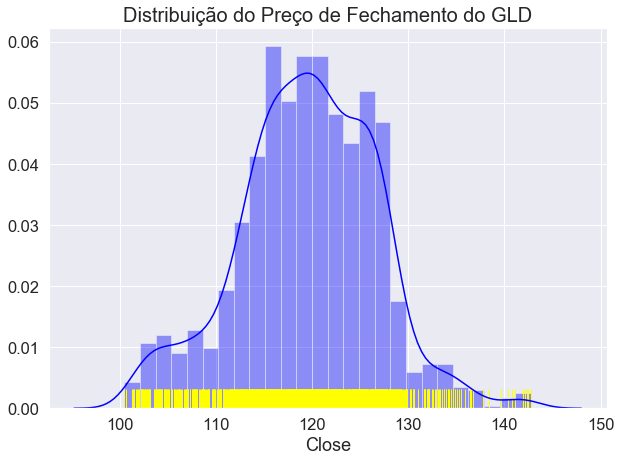

In [42]:
#Histograma do Fechamento do GLD
plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(treinamento_dataset_GLD['Close'], color= 'yellow')
sns.distplot(treinamento_dataset_GLD['Close'], color= 'blue')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento do GLD')

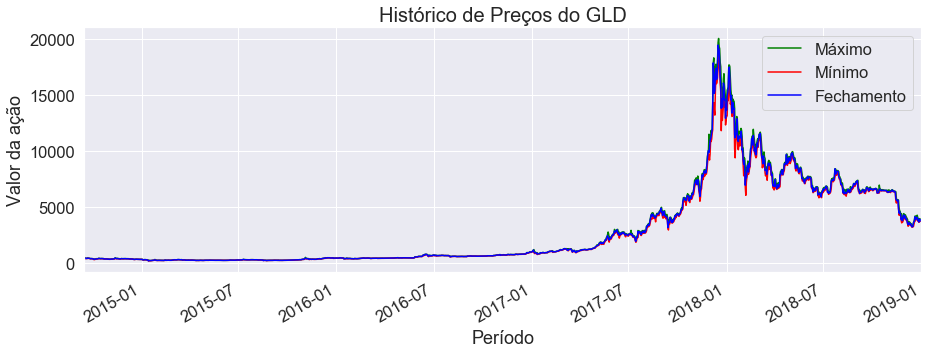

In [43]:
#Plotagem da série histórica do BTC-USD utilizando o máximo, mínimo e fechamento.
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['High'].plot(label = 'Máximo', color = 'green')
treinamento_dataset_BTC_USD['Low'].plot(label = 'Mínimo', color = 'red')
treinamento_dataset_BTC_USD['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do GLD')
plt.legend();

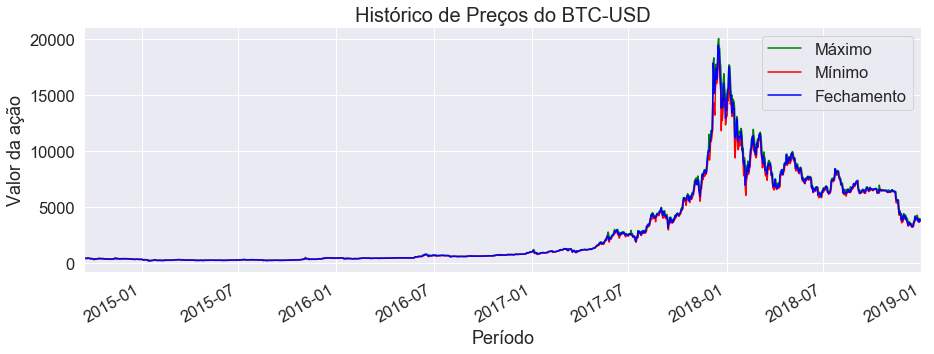

In [44]:
#Plotagem da série histórica do BTC-USD utilizando o máximo, mínimo e fechamento.
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['High'].plot(label = 'Máximo', color = 'green')
treinamento_dataset_BTC_USD['Low'].plot(label = 'Mínimo', color = 'red')
treinamento_dataset_BTC_USD['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do BTC-USD')
plt.legend();

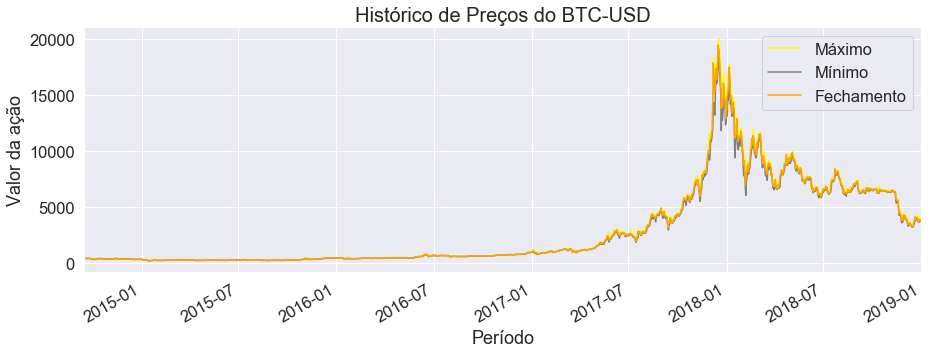

In [45]:
#Plotagem da série histórica do BTC-USD utilizando o máximo, mínimo e fechamento.
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['High'].plot(label = 'Máximo', color = 'yellow')
treinamento_dataset_BTC_USD['Low'].plot(label = 'Mínimo', color = 'gray')
treinamento_dataset_BTC_USD['Close'].plot(label = 'Fechamento', color = 'orange')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do BTC-USD')
plt.legend();

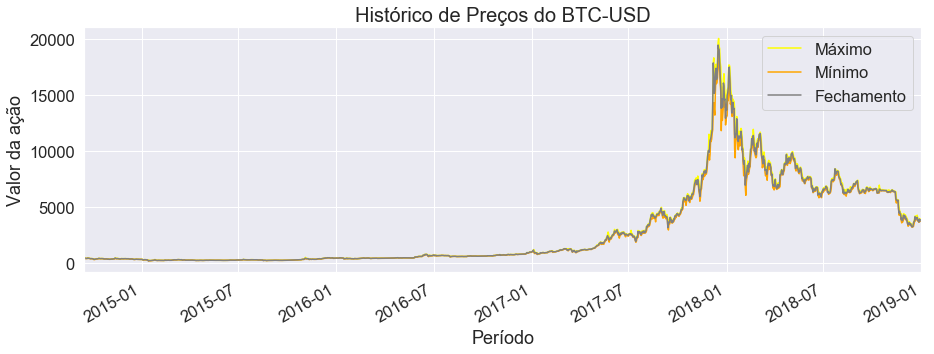

In [46]:
#Plotagem da série histórica do BTC-USD utilizando o máximo, mínimo e fechamento.
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['High'].plot(label = 'Máximo', color = 'yellow')
treinamento_dataset_BTC_USD['Low'].plot(label = 'Mínimo', color = 'orange')
treinamento_dataset_BTC_USD['Close'].plot(label = 'Fechamento', color = 'gray')
plt.ylabel('Valor da ação')
plt.xlabel('Período')
plt.title('Histórico de Preços do BTC-USD')
plt.legend();

Text(0.5, 1.0, 'Variação de preço diário do BTC-USD')

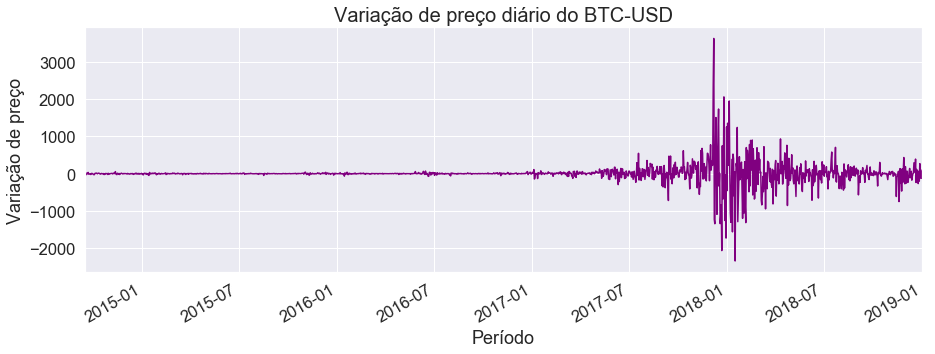

In [47]:
#Plotagem da variação de preço
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['Variation'].plot(label = 'Variação de preço', color = 'purple')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário do BTC-USD')

In [50]:
#Retorna a data com a maior variação entre o preço de abertura e fechamento
max_variation_BTC_USD = treinamento_dataset_BTC_USD['Variation'].values.argmax()
max_value_BTC_USD = treinamento_dataset_BTC_USD['Variation'].values[max_variation_BTC_USD,]
treinamento_dataset_BTC_USD['Variation'][treinamento_dataset_BTC_USD['Variation'].values == max_value_BTC_USD]

Date
2017-12-07    3633.599609
Name: Variation, dtype: float64

In [52]:
#O describe é utilizado para retornar uma descrição estatistica.
treinamento_dataset_BTC_USD.describe()

,High,Low,Open,Close,Volume,Adj Close,Variation
count,1568.000000,1568.000000,1568.000000,1568.000000,1.568000e+03,1568.000000,1568.000000
mean,3004.183923,2817.755218,2916.459327,2918.367399,1.998481e+09,2918.367399,1.908072
std,3868.218540,3559.448876,3729.664555,3728.962180,3.383297e+09,3728.962180,269.343916
min,211.731003,171.509995,176.897003,178.102997,5.914570e+06,178.102997,-2345.599609
25%,379.126740,363.145500,371.203262,370.957756,4.040165e+07,370.957756,-8.393250
50%,737.738495,708.824493,719.798004,726.533020,1.149075e+08,726.533020,1.018997
75%,5838.350098,5522.435059,5715.119873,5712.787476,3.534788e+09,5712.787476,16.293533
max,20089.000000,18974.099609,19475.800781,19497.400391,2.384090e+10,19497.400391,3633.599609


Text(0.5, 1.0, 'Volume negociado do BTC-USD')

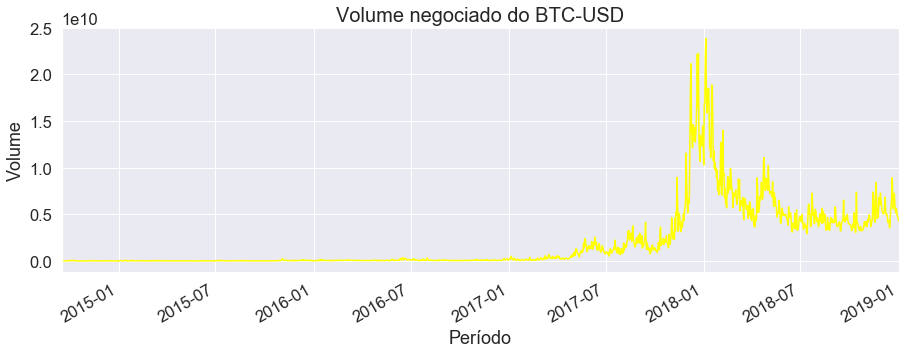

In [54]:
#Plotagem do volume 
plt.figure(figsize=(15,5))
treinamento_dataset_BTC_USD['Volume'].plot(label = 'Volume', color = 'yellow')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado do BTC-USD')